In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from my_modules.plot_and_stat_funcs import *
from my_modules.transformations import *
import seaborn as sns
from functools import partial
from sklearn.cluster import KMeans
import pickle
import datetime

from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def RMSPE(y_true, y_pred):
    y_t, y_p = np.array(y_true), np.array(y_pred)
    y_t, y_p = y_t[y_t != 0], y_p[y_t != 0]
    return np.sqrt(np.mean(
        ((y_t - y_p) / y_t)**2
    ))

In [3]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv').target
X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv').target

In [4]:
train_sales = pd.concat([X_train, y_train], axis=1)
val_sales = pd.concat([X_val, y_val], axis=1)
ts = time_series(train_sales, store_id=1)
val_ts = time_series(val_sales, store_id=1, all_values=range(894, 894 + 48))

In [5]:
store_ids = train_sales.Store.unique()
train_days = np.sort(train_sales.ordered_day.unique())
train_time_series = pd.DataFrame({
                store_id: time_series(train_sales, store_id=store_id, all_values=train_days).values
                for store_id in store_ids
            })

In [6]:
all_sales = pd.concat([train_sales, val_sales], axis=0, ignore_index=True)

In [22]:
all_store_ids = all_sales.Store.unique()
all_days = np.sort(all_sales.ordered_day.unique())
all_time_series = pd.DataFrame({
                store_id: time_series(all_sales, store_id=store_id, all_values=all_days).values
                for store_id in store_ids
            })

# TripleSmoothingModel

$l_x=\alpha(y_x-s_{x-L})+(1-\alpha)(l_{x-1}+b_{x-1})$  
$b_x=\beta(l_x-l_{x-1})+(1-\beta)b_{x-1}$  
$s_x=\gamma(y_x-l_x)+(1-\gamma)s_{x-L}$  
$\hat{y}_{x+m}=l_x+mb_x+s_{x-L+1+(m-1)modL}$

In [7]:
class HoltWinters:

    """
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса

    """

    def __init__(self, slen, alpha, beta, gamma):
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initial_trend(self):
        s = 0.0
        for i in range(self.slen):
            s += (self.series[i+self.slen] - self.series[i]) / self.slen
        return s / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def fit(self, series):
        self.series = series
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        
        # инициализируем значения компонент
        self.seasonals = self.initial_seasonal_components()
        smooth = self.series[0]
        trend = self.initial_trend()
        self.result.append(self.series[0])
        self.Smooth.append(smooth)
        self.Trend.append(trend)
        self.Season.append(self.seasonals[0])


        for i in range(1, len(self.series)):
            val = self.series[i]
            last_smooth, smooth = smooth, self.alpha*(val-self.seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
            trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
            self.seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*self.seasonals[i%self.slen]
            self.result.append(smooth+trend+self.seasonals[i%self.slen])
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(self.seasonals[i % self.slen])


        self.Smooth.append(smooth)
        self.Trend.append(trend)
        self.Season.append(self.seasonals[i % self.slen])
        return np.array(self.result)
    
    def predict(self, n_preds):
        smooth = self.Smooth[-1]
        trend = self.Trend[-1]
        result = []
        for i in range(len(self.series), len(self.series)+n_preds):
            m = i - len(self.series) + 1
            result.append((smooth + m*trend) + self.seasonals[i%self.slen])

        return np.array(result)
    
    def predict_from_start(self, n_preds):
        return np.append(self.result, self.predict(n_preds), axis=0)

In [8]:
class TripleExpSmoothingCommon:
    
    def __init__(self, slen, alpha, beta, gamma):
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def fit(self, all_time_series):
        
        self.train_days = np.sort(all_time_series.index)
        self.store_ids = np.array(all_time_series.columns)
        self.all_time_series = all_time_series.copy()
        
        self.model = HoltWinters(self.slen, self.alpha, self.beta, self.gamma)
        self.model.fit(self.all_time_series.values)
        return self
    
    def predict(self, X_test):
        stores = X_test.Store.unique()
        n_preds = X_test.ordered_day.max() - self.train_days.max()
        prediction = self.model.predict(n_preds)
        prediction = pd.DataFrame(prediction, columns=self.all_time_series.columns)\
                .unstack().reset_index().rename(columns={'level_0': 'Store', 'level_1': 'ordered_day', 0: 'prediction'})
        prediction.ordered_day += self.train_days.max() + 1
        return X_test.merge(prediction, on=['Store', 'ordered_day']).prediction.values

In [9]:
def tesc_err(x, slen, val_sales=val_sales, all_time_series=train_time_series):
    tesc = TripleExpSmoothingCommon(slen, *x).fit(all_time_series=all_time_series)
    return RMSPE(val_sales.target, tesc.predict(val_sales))

# ClusteredModel

In [10]:
class ClusteredModel:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, val_sales=val_sales, all_time_series=train_time_series):
        all_time_series = all_time_series.loc[:, all_time_series.columns.sort_values()]
        all_ts = all_time_series.values.T
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=481).fit(all_ts)
        labels = kmeans.labels_

        self.store_ids = {
            label: all_time_series.columns[labels == label]
            for label in range(self.n_clusters)
        }
        self.models = []
        cube_vertices = list(product([0, 1], repeat=3))
        for label in range(self.n_clusters):
            ts_label = all_time_series.loc[:, labels==label]
            val = val_sales[val_sales.Store.isin(self.store_ids[label])]
            errs = []
            for vertex in cube_vertices:
                res = minimize(
                    lambda x: tesc_err(x, 14, val_sales=val, all_time_series=ts_label),
                    x0=vertex,
                    bounds=[(0, 1), (0, 1), (0, 1)]
                )
                errs.append((res.x, res.fun))
            best_params, err = min(errs, key=lambda x: x[1])
            tesc = TripleExpSmoothingCommon(14, *best_params).fit(all_time_series=ts_label)
            self.models.append(tesc)

    def refit(self, all_time_series=train_time_series):
        for label in range(self.n_clusters):
            ts_label = all_time_series.loc[:, all_time_series.columns.isin(self.store_ids[label])]
            self.models[label].fit(ts_label)

    def predict(self, X_test):
        
        pred = np.zeros(len(X_test))
        for label in range(self.n_clusters):
            store_mask = X_test.Store.isin(self.store_ids[label])
            if (~store_mask).all():
                continue
            pred[store_mask] = self.models[label].predict(X_test[store_mask])
        return pred

One model for all

In [11]:
cm_common = ClusteredModel(1)
cm_common.fit(val_sales, train_time_series)
cm_common_prediction = cm_common.predict(val_sales)

In [12]:
RMSPE(val_sales.target, cm_common_prediction)

0.19432526024571975

Different models for different clusters

In [13]:
cm = ClusteredModel(100)
cm.fit(val_sales, train_time_series)
cm_prediction = cm.predict(val_sales)

In [14]:
RMSPE(val_sales.target, cm_prediction)

0.18072544850653002

In [18]:
with open('data/ClusteredModel.pickle', 'wb') as f:
    pickle.dump(cm, f)

# Autoregression

In [15]:
class ARPredictor:
    def __init__(self, lags):
        self.lags = lags
        
    def fit(self, all_time_series=all_time_series):
        
        self.train_days = np.array(all_time_series.index)
        self.store_ids = all_time_series.columns.unique()
        self.all_time_series = all_time_series.copy()
               
        self.all_models = {
            store_id: self.fit_model(self.all_time_series[store_id])
            for store_id in self.store_ids
        }
        return self
    
    def fit_model(self, ts):
        return AutoReg(ts.values, self.lags, old_names=True).fit()
    
    def predict_time_series(self, auto_reg_model, n_preds):
        start_day = self.train_days.max() + 1
        return auto_reg_model.predict(start=start_day, end=start_day + n_preds - 1)
    
    def predict(self, X_test):
        test_stores = X_test.Store.unique()
        all_days = np.sort(X_test.ordered_day.unique())
        n_preds = all_days.max() - self.train_days.max()
        start_pred, end_pred = self.train_days.max() + 1, all_days.max()
        predictions = [
            list(zip(
                [store_id] * n_preds,
                range(start_pred, end_pred + 1),
                self.predict_time_series(self.all_models[store_id], n_preds)
            ))
            for store_id in test_stores
        ]
        predictions = np.reshape(predictions, (np.size(predictions) // 3, 3))
        predictions = pd.DataFrame(predictions, columns=['Store', 'ordered_day', 'prediction'])
        return X_test.merge(predictions, on=['Store', 'ordered_day'])[['Store', 'ordered_day', 'prediction']].prediction

In [19]:
arp_errs = []
lag_values = range(1, 31)
for lags in lag_values:
    arp = ARPredictor(lags).fit(train_time_series)
    val_predict = arp.predict(val_sales)
    arp_errs.append(RMSPE(val_sales.target, val_predict))

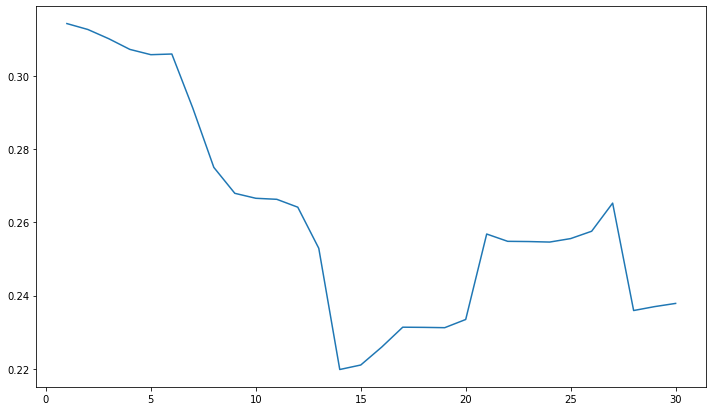

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(lag_values, arp_errs)
plt.show()

In [21]:
min(arp_errs)

0.21975773107170152

The result is worse than for clustered model.

Submitting

In [33]:
X_test = pd.read_csv('data/X_test.csv')

In [34]:
X_test.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",Encoded_Customers,Encoded_sum_target
0,1,4,1,0,0,989,141,32,8,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,1,3,1,0,0,988,141,32,8,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,1,2,1,0,0,987,141,32,8,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,1,1,1,0,0,986,140,32,8,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,1,6,0,0,0,984,140,32,8,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [26]:
cm.refit(all_time_series)

In [37]:
test = pd.read_csv('data/test.csv')

In [41]:
test['ordered_day'] = test.Date.apply(lambda date: (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime(2013, 1, 1)).days)
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,ordered_day
0,1,1,4,2015-09-17,1.0,1,0,0,989
1,2,3,4,2015-09-17,1.0,1,0,0,989
2,3,7,4,2015-09-17,1.0,1,0,0,989
3,4,8,4,2015-09-17,1.0,1,0,0,989
4,5,9,4,2015-09-17,1.0,1,0,0,989


In [42]:
prediction = cm.predict(X_test).clip(0)

In [44]:
X_test['prediction'] = prediction

In [48]:
pred_df = test[['Id', 'Store', 'ordered_day']].merge(X_test[['Store', 'ordered_day', 'prediction']], on=['Store', 'ordered_day'])
pred_df.head()

,Id,Store,ordered_day,prediction
0,1,1,989,3810.878982
1,2,3,989,6477.637165
2,3,7,989,9708.747801
3,4,8,989,6041.119062
4,5,9,989,6540.730871


In [57]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head(1)

,Id,Sales
0,1,0


In [58]:
submission = submission.merge(pred_df, on='Id', how='left')[['Id', 'prediction']].fillna(0).rename(columns={'prediction': 'Sales'})

In [59]:
submission.head()

,Id,Sales
0,1,3810.878982
1,2,6477.637165
2,3,9708.747801
3,4,6041.119062
4,5,6540.730871


In [60]:
submission.to_csv('data/submission_1.csv', index=False)

score - 0.29496

# Analysis of error